In [1]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

%matplotlib inline

- 1,447 likely voters surveyed
- Responses given:
    - Bush: 727
    - Dukakis: 583
    - Other: 137
- What is the probability that more people will vote for Bush over Dukakis

In [78]:
n = 1447
y = [727, 583, 137]
k = 3    

In [79]:
with pm.Model() as model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a)
    
    bush_dukakis_diff = pm.Deterministic("bush_dukakis_diff", theta[0] - theta[1])
    
    likelihood = pm.Multinomial("likelihood", n=n, p=theta, observed=y)

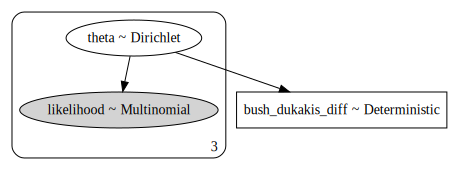

In [80]:
pm.model_to_graphviz(model)

In [81]:
with model:
    trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4645.46draws/s]


/Users/claus/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


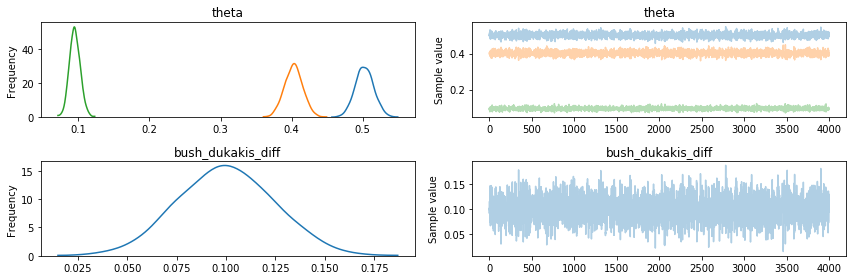

In [82]:
with model:
    pm.traceplot(trace, combined=True)

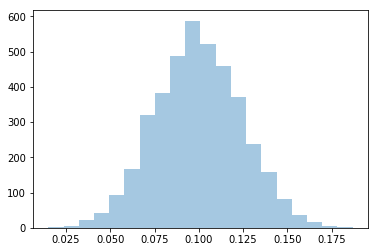

In [83]:
sns.distplot(trace["bush_dukakis_diff"], bins=20, kde=False);